In [411]:
import numpy as np
import random
import matplotlib.pyplot as plt

from scipy.special import logsumexp
from sklearn.linear_model import Ridge
from sklearn.mixture import GaussianMixture
from sklearn.metrics import r2_score, mean_squared_error

import torch
import torch.distributions as D

from clusterless import preprocess
from clusterless import decoder

In [412]:
seed = 666
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.set_default_dtype(torch.double)

In [413]:
SMALL_SIZE = 15
MEDIUM_SIZE = 20
BIGGER_SIZE = 25

plt.rc('font', size=MEDIUM_SIZE)         
plt.rc('axes', titlesize=MEDIUM_SIZE)     
plt.rc('axes', labelsize=MEDIUM_SIZE) 
plt.rc('axes', linewidth = 1.5)
plt.rc('xtick', labelsize=MEDIUM_SIZE)   
plt.rc('ytick', labelsize=MEDIUM_SIZE)   
plt.rc('legend', fontsize=MEDIUM_SIZE)   
plt.rc('figure', titlesize=MEDIUM_SIZE)

#### load data

In [414]:
pid = 'dab512bd-a02d-4c1f-8dbc-9155a163efc0'
rootpath = '/mnt/3TB/yizi/Downloads/ONE/openalyx.internationalbrainlab.org'
trial_data_path = rootpath + '/danlab/Subjects/DY_016/2020-09-12/001/alf'
neural_data_path = '/mnt/3TB/yizi/danlab/Subjects/DY_016'
behavior_data_path = rootpath + '/paper_repro_ephys_data/figure9_10/original_data'
save_path = '../saved_results/danlab/Subjects/DY_016/cavi_results/'

In [415]:
unsorted_trials, stim_on_times, np1_channel_map = preprocess.load_neural_data(
    pid=pid, 
    trial_data_path=trial_data_path,
    neural_data_path=neural_data_path,
    behavior_data_path=behavior_data_path,
    keep_active_trials=True, 
    roi='all',
    kilosort=False,
    triage=False
)

behave_dict = preprocess.load_behaviors_data(behavior_data_path, pid)
motion_energy, wheel_velocity, wheel_speed, paw_speed, nose_speed, pupil_diameter = preprocess.preprocess_dynamic_behaviors(behave_dict)

pid: dab512bd-a02d-4c1f-8dbc-9155a163efc0
eid: d23a44ef-1402-4ed7-97f5-47e9a7a504d9
1st trial stim on time: 17.56, last trial stim on time 2310.24


In [416]:
class DataLoader():
    def __init__(self, data, y, stim_on_times, np1_channel_map, n_t_bins=30):
        self.data = data
        self.y = y
        self.stim_on_times = stim_on_times
        self.np1_channel_map = np1_channel_map
        self.n_t_bins = n_t_bins
        self.n_trials = stim_on_times.shape[0]
        self.n_channels = np1_channel_map.shape[0]
        self.t_binning = np.arange(0, 1.5, step = (1.5 - 0) / n_t_bins)
        self.rand_trial_ids = np.arange(self.n_trials)
        
        # allocate unsorted data into trials
        self.trial_ids = []
        self.t_ids = []
        self.trials = []
        self.t_bins = []
        for k in range(self.n_trials):
            mask = np.logical_and(data[:,0] >= stim_on_times[k] - 0.5,
                                  data[:,0] <= stim_on_times[k] + 1)
            trial = data[mask,:]
            trial[:,0] = trial[:,0] - trial[:,0].min()
            t_bins = np.digitize(trial[:,0], self.t_binning, right = False) - 1
            t_bin_lst = []
            for t in range(self.n_t_bins):
                t_bin = trial[t_bins == t,1:]
                self.trial_ids.append(np.ones_like(t_bin[:,0]) * k)
                self.t_ids.append(np.ones_like(t_bin[:,0]) * t)
                t_bin_lst.append(t_bin)
            self.trials.append(t_bin_lst)
    
    
    def split_train_test(self, split=.8):
        
        self.train_ids = self.rand_trial_ids[:int(split * self.n_trials)]
        self.test_ids = self.rand_trial_ids[int(split * self.n_trials):]
        self.y_train = self.y[self.train_ids]
        self.y_test = self.y[self.test_ids]
        
        trial_ids = np.concatenate(self.trial_ids)
        t_ids = np.concatenate(self.t_ids)
        trials = np.concatenate(np.concatenate(self.trials))

        train_mask = np.sum([trial_ids == idx for idx in self.train_ids], axis=0).astype(bool)
        test_mask = np.sum([trial_ids == idx for idx in self.test_ids], axis=0).astype(bool)
        train_k_ids, test_k_ids = trial_ids[train_mask], trial_ids[test_mask]
        train_t_ids, test_t_ids = t_ids[train_mask], t_ids[test_mask]
        train_trials, test_trials = trials[train_mask], trials[test_mask]
        
        return train_trials, train_k_ids, train_t_ids, \
               test_trials, test_k_ids, test_t_ids

In [417]:
data_loader = DataLoader(data = np.concatenate(unsorted_trials)[:,[0,2,3,4]], 
                         y = wheel_velocity, 
                         stim_on_times = stim_on_times, 
                         np1_channel_map = np1_channel_map, 
                         n_t_bins=30)

In [418]:
train_trials, train_k_ids, train_t_ids, _, _, _ = data_loader.split_train_test(split=.8)

<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [419]:
train_trials.shape

(594171, 3)

In [421]:
gmm = GaussianMixture(n_components=50, 
                      covariance_type='full', 
                      init_params='k-means++',
                      verbose=1)
gmm.fit(train_trials)

Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
Initialization converged: True


GaussianMixture(init_params='k-means++', n_components=50, verbose=1)

In [422]:
s = torch.tensor(train_trials)
y = torch.tensor(data_loader.y_train)
ks = torch.tensor(train_k_ids)
ts = torch.tensor(train_t_ids)

Nk = len(data_loader.train_ids)
Nt = data_loader.n_t_bins
Nc = gmm.means_.shape[0]
Nd = gmm.means_.shape[1]

#### CAVI-SGD

In [423]:
def safe_log(x, minval=1e-10):
    return torch.log(x + minval)

In [424]:
class SVI(torch.nn.Module):

    def __init__(self, Nk, Nt, Nc, Nd, init_means, init_covs):
        super(SVI, self).__init__()
        self.Nk = Nk
        self.Nt = Nt
        self.Nc = Nc
        self.Nd = Nd
        
        # variational distribution variables for means
        # precision ~ Gamma(a, b) = var^{-1}
        self.mu_locs = torch.nn.Parameter(torch.tensor(init_means))
        self.mu_stds = torch.nn.Parameter(torch.pow(D.gamma.Gamma(5, 5).sample((Nc, Nd)), -0.5))
        
        # variational distribution variables for covariances
        self.cov_covs = torch.nn.Parameter(torch.tensor(init_covs))
        
        # fixed parameters
        self.bs = torch.nn.Parameter(torch.randn((Nc)))
        self.betas = torch.nn.Parameter(torch.randn((Nc, Nt, Nt)))
                                          
        # prior distributions for means
        self.mu_prior = D.normal.Normal(loc=torch.tensor(init_means), scale=torch.ones((Nc, Nd)))

        # prior distributions for covariances
        self.cov_prior = D.wishart.Wishart(df=Nc+1, covariance_matrix=torch.tensor(init_covs))

        
    def forward(self, s, y, ks, ts, sampling=True):
                                         
        # variational distributions
        mu = D.normal.Normal(loc=self.mu_locs, scale=torch.clamp(self.mu_stds, .1, torch.inf))
        cov = D.wishart.Wishart(df=self.Nc+1, covariance_matrix=self.cov_covs)
        
        # mixing proportions 
        log_lambdas = torch.zeros((self.Nk, self.Nc, self.Nt))
        for k in range(self.Nk):
            for t in range(self.Nt):
                log_lambdas[k,:,t] = self.bs + self.betas[:,t] @ y[k]
        log_pis = log_lambdas - torch.logsumexp(log_lambdas, 1)[:,None,:]
                                          
                                          
        # sample from the variational distributions
        if sampling:
            Nb = s.shape[0] # num of samples in the batch
            mu_sample = mu.sample((Nb,))
            cov_sample = cov.sample((Nb,))
        else:
            mu_sample = mu.loc.reshape((1, self.Nc, self.Nd))
            cov_sample = cov.covariance_matrix.reshape((1, self.Nc, self.Nd, self.Nd))
            
            
        pi_sample = torch.zeros((s.shape[0], self.Nc))
        for k in range(self.Nk):
            for t in range(self.Nt):
                k_t_idx = torch.logical_and(ks == torch.unique(ks).int()[k], ts == t)
                pi_sample[k_t_idx] = torch.exp(log_pis)[k,:,t]
                                          
                            
        # mixture density
        density = D.mixture_same_family.MixtureSameFamily(
            mixture_distribution=D.categorical.Categorical(probs=pi_sample),
            component_distribution=
                D.multivariate_normal.MultivariateNormal(
                                           loc=mu_sample,
                                           covariance_matrix=cov_sample)
                )
                               
                                          
        # compute the mean log likelihood
        log_likelihoods = density.log_prob(s)
        
                                          
        # compute the KL divergence sum
        mu_div = torch.sum(D.kl.kl_divergence(mu, self.mu_prior))
        cov_div = torch.sum(D.kl.kl_divergence(cov, self.cov_prior))
        kl_sum = mu_div + cov_div 
                                          
        return log_likelihoods, kl_sum

In [425]:
batch_size = 6
batch_ids = list(zip(*(iter(data_loader.train_ids),) * batch_size))

In [426]:
svi = SVI(batch_size, Nt, Nc, Nd, gmm.means_, gmm.covariances_)
optim = torch.optim.Adam(svi.parameters(), lr=1e-2)

In [427]:
%%time
max_iter = 100
elbos = []
N = s.shape[0]
for i in range(max_iter):
    tot_elbo = 0
    for n, batch_idx in enumerate(batch_ids): 
        mask = torch.logical_and(ks >= batch_idx[0], ks <= batch_idx[-1])
        batch_s = s[mask]
        batch_y = y[list(batch_idx)]
        batch_ks = ks[mask]
        batch_ts = ts[mask]
        log_likelihoods, kl_sum = svi(batch_s, batch_y, batch_ks, batch_ts)
        batch_elbo = torch.mean(log_likelihoods) - kl_sum/N
        tot_elbo += batch_elbo
        loss = - batch_elbo
        loss.backward()
        if (n+1) % 10 == 0:
            print(f'iter: {i+1} batch {n+1}')
        optim.step()
        optim.zero_grad()
    print(f'iter: {i+1} total elbo: {tot_elbo:.2f}')
    elbos.append(tot_elbo)

/home/yizi/anaconda3/envs/clusterless/lib/python3.8/site-packages/torch/distributions/wishart.py:250: UserWarning: Singular sample detected.
  warnings.warn("Singular sample detected.")


iter: 1 batch 10
iter: 1 batch 20
iter: 1 batch 30
iter: 1 total elbo: -683.59
iter: 2 batch 10
iter: 2 batch 20
iter: 2 batch 30
iter: 2 total elbo: -635.04
iter: 3 batch 10
iter: 3 batch 20
iter: 3 batch 30
iter: 3 total elbo: -623.75
iter: 4 batch 10
iter: 4 batch 20
iter: 4 batch 30
iter: 4 total elbo: -619.12
iter: 5 batch 10
iter: 5 batch 20
iter: 5 batch 30
iter: 5 total elbo: -616.37
iter: 6 batch 10
iter: 6 batch 20
iter: 6 batch 30
iter: 6 total elbo: -614.26
iter: 7 batch 10
iter: 7 batch 20
iter: 7 batch 30
iter: 7 total elbo: -612.67
iter: 8 batch 10
iter: 8 batch 20
iter: 8 batch 30
iter: 8 total elbo: -611.22
iter: 9 batch 10
iter: 9 batch 20
iter: 9 batch 30
iter: 9 total elbo: -610.17
iter: 10 batch 10
iter: 10 batch 20
iter: 10 batch 30
iter: 10 total elbo: -608.99
iter: 11 batch 10
iter: 11 batch 20
iter: 11 batch 30
iter: 11 total elbo: -607.93
iter: 12 batch 10
iter: 12 batch 20
iter: 12 batch 30
iter: 12 total elbo: -607.10
iter: 13 batch 10
iter: 13 batch 20
iter

In [428]:
elbos = [elbo.detach().numpy() for elbo in elbos]

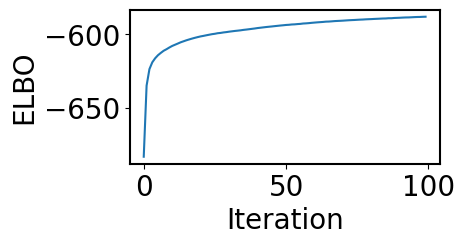

In [429]:
plt.figure(figsize=(4,2))
plt.plot(elbos)
plt.xlabel("Iteration")
plt.ylabel("ELBO");

In [430]:
log_lambdas = torch.zeros((Nk, Nc, Nt))
for k in range(Nk):
    for t in range(Nt):
        log_lambdas[k,:,t] = svi.bs + svi.betas[:,t] @ y[k]

log_pis = log_lambdas - torch.logsumexp(log_lambdas, 1)[:,None,:]

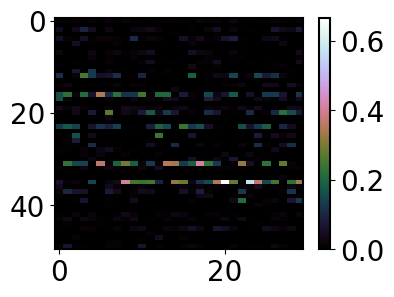

In [438]:
plt.figure(figsize=(4,3))
plt.imshow(torch.exp(log_pis[-10]).detach().numpy(), 
           aspect='auto', cmap='cubehelix')
plt.colorbar();

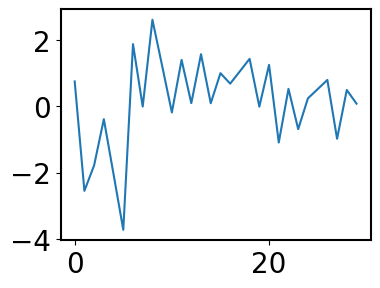

In [441]:
plt.figure(figsize=(4,3))
plt.plot(svi.betas[0,15].detach().numpy());

In [442]:
# svi.mu_locs

In [443]:
# gmm.means_

In [447]:
cont_y_enc_res = {
    'bs': svi.bs,
    'betas': svi.betas,
    'means': svi.mu_locs,
    'covs': svi.cov_covs
}
np.save(save_path + f'cont_y_enc_res_c{Nc}.npy', cont_y_enc_res)

#### MoG only

In [448]:
all_trials = np.concatenate(np.concatenate(data_loader.trials))
spike_times = data_loader.data[:,0]

spike_labels = []
spike_probs = []
spike_labels.extend(gmm.predict(all_trials))
spike_probs.extend(gmm.predict_proba(all_trials))
spike_labels = np.array(spike_labels)
spike_probs = np.array(spike_probs)

<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [449]:
enc_gmm = preprocess.compute_neural_activity(
    (spike_times, spike_labels, spike_probs),
    data_loader.stim_on_times,
    'clusterless', 
    n_time_bins=data_loader.n_t_bins
)
print(enc_gmm.shape)

(265, 50, 30)


In [450]:
train = np.arange(data_loader.n_trials)[:int(.8*data_loader.n_trials)]
test = np.arange(data_loader.n_trials)[int(.8*data_loader.n_trials):]

x_train = enc_gmm.reshape(-1, enc_gmm.shape[1] * enc_gmm.shape[2])[train]
x_test = enc_gmm.reshape(-1, enc_gmm.shape[1] * enc_gmm.shape[2])[test]
y_train = data_loader.y[train]

ridge = Ridge(alpha=10000)
ridge.fit(x_train, y_train)
y_hat = ridge.predict(x_test)

In [451]:
print(f'R2 = {r2_score(data_loader.y[test], y_hat):.3f}')
print(f'MSE = {mean_squared_error(data_loader.y[test], y_hat):.3f}')

R2 = 0.062
MSE = 1.402


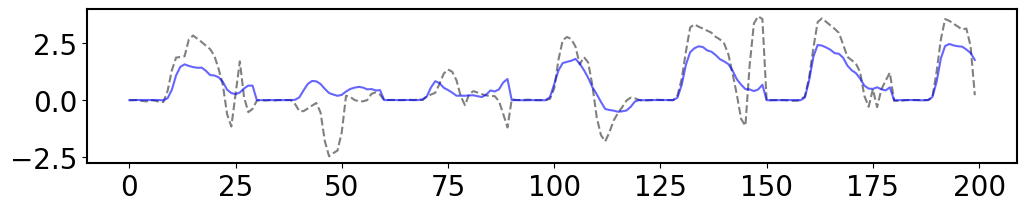

In [452]:
plt.figure(figsize=(12, 2))
plt.plot(data_loader.y[test].flatten()[:200], c='gray', linestyle='dashed', label='observed');
plt.plot(y_hat.flatten()[:200], c='blue', alpha=.6, label='predicted');

In [453]:
windowed_enc_gmm, half_window_size, n_windows = decoder.sliding_window(
    enc_gmm, 
    data_loader.n_trials,
    window_size = 7
)
windowed_y = data_loader.y[:,half_window_size:n_windows].reshape(-1,1)

In [454]:
x_by_trial = windowed_enc_gmm.reshape((data_loader.n_trials, -1))
y_by_trial = windowed_y.reshape((data_loader.n_trials, -1))
x_train, x_test = x_by_trial[train], x_by_trial[test]
y_train, y_test = y_by_trial[train], y_by_trial[test]

x_train = x_train.reshape((-1, windowed_enc_gmm.shape[1]))
x_test = x_test.reshape((-1, windowed_enc_gmm.shape[1]))
y_train = y_train.flatten()
y_test = y_test.flatten()

ridge = Ridge(alpha=10000)
ridge.fit(x_train, y_train)
y_pred = ridge.predict(x_test)

In [455]:
print(f'R2 = {r2_score(y_test, y_pred):.3f}')
print(f'MSE = {mean_squared_error(y_test, y_pred):.3f}')

R2 = 0.098
MSE = 1.899


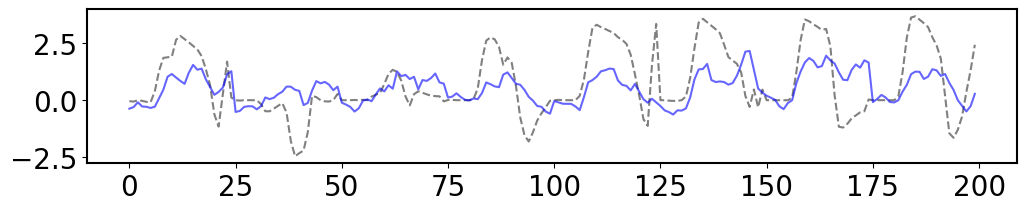

In [456]:
plt.figure(figsize=(12, 2))
plt.plot(y_test[:200], c='gray', linestyle='dashed', label='observed');
plt.plot(y_pred[:200], c='blue', alpha=.6, label='predicted');

#### encoding MoG

In [457]:
n_trials = stim_on_times.shape[0]
unsorted = np.vstack([unsorted_trials[i] for i in np.arange(n_trials)]) 
spike_times = unsorted[:,0]
spike_channels = unsorted[:,1]
spike_features = unsorted[:,2:]

thresholded_neural_data = preprocess.compute_neural_activity(
    (spike_times, spike_channels),
    stim_on_times,
    'thresholded', 
    n_time_bins=10,
    # regional=True
    regional=False
)
print(f'thresholded neural data shape: {thresholded_neural_data.shape}')

thresholded neural data shape: (265, 384, 10)


In [458]:
x_train = thresholded_neural_data.reshape(-1, thresholded_neural_data.shape[1] * thresholded_neural_data.shape[2])[train]
x_test = thresholded_neural_data.reshape(-1, thresholded_neural_data.shape[1] * thresholded_neural_data.shape[2])[test]
y_train = data_loader.y[train]

ridge = Ridge(alpha=10000)
ridge.fit(x_train, y_train)
y_hat = ridge.predict(x_test)

In [459]:
print(f'R2 = {r2_score(data_loader.y[test], y_hat):.3f}')
print(f'MSE = {mean_squared_error(data_loader.y[test], y_hat):.3f}')

R2 = 0.147
MSE = 1.222


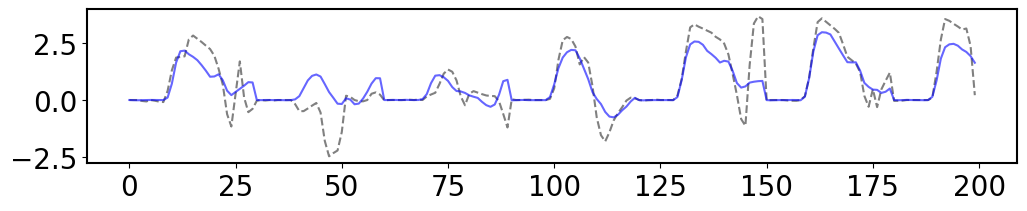

In [460]:
plt.figure(figsize=(12, 2))
plt.plot(data_loader.y[test].flatten()[:200], c='gray', linestyle='dashed', label='observed');
plt.plot(y_hat.flatten()[:200], c='blue', alpha=.6, label='predicted');

In [461]:
log_lambdas_hat = np.zeros((data_loader.n_trials, Nc, Nt))
for k in range(len(train)):
    for t in range(Nt):
        log_lambdas_hat[k,:,t] = svi.bs.detach().numpy() + svi.betas[:,t].detach().numpy() @ y_train[k]

for k in range(len(test)):
    for t in range(Nt):
        log_lambdas_hat[k,:,t] = svi.bs.detach().numpy() + svi.betas[:,t].detach().numpy() @ y_hat[k]

log_pis_hat = log_lambdas_hat - logsumexp(log_lambdas_hat, 1)[:,None,:]

In [462]:
enc_pis = np.exp(log_pis_hat)
enc_means = svi.mu_locs.detach().numpy()
enc_covs = svi.cov_covs.detach().numpy()

In [463]:
enc_all = np.zeros((data_loader.n_trials, Nc, Nt))

for k in range(enc_all.shape[0]):
    for t in range(Nt):
        enc_gmm =  GaussianMixture(n_components=Nc, covariance_type='full')
        enc_gmm.precisions_cholesky_ = np.linalg.cholesky(np.linalg.inv(enc_covs))
        enc_gmm.weights_ = enc_pis[k,:,t]
        enc_gmm.means_ = enc_means
        enc_gmm.covariances_ = enc_covs
        enc_all[k,:,t] = enc_gmm.predict_proba(data_loader.trials[k][t]).sum(0)

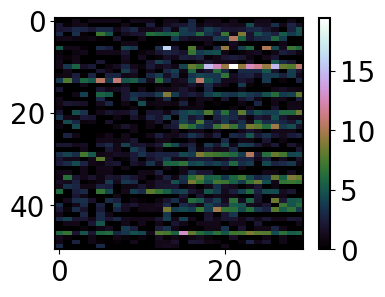

In [470]:
plt.figure(figsize=(4,3))
plt.imshow(enc_all[-10], aspect='auto', cmap='cubehelix')
plt.colorbar();

In [471]:
train = np.arange(data_loader.n_trials)[:int(.8*data_loader.n_trials)]
test = np.arange(data_loader.n_trials)[int(.8*data_loader.n_trials):]

x_train = enc_all.reshape(-1, enc_all.shape[1] * enc_all.shape[2])[train]
x_test = enc_all.reshape(-1, enc_all.shape[1] * enc_all.shape[2])[test]
y_train = data_loader.y[train]

ridge = Ridge(alpha=10000)
ridge.fit(x_train, y_train)
y_hat = ridge.predict(x_test)

In [472]:
print(f'R2 = {r2_score(data_loader.y[test], y_hat):.3f}')
print(f'MSE = {mean_squared_error(data_loader.y[test], y_hat):.3f}')

R2 = -0.259
MSE = 2.166


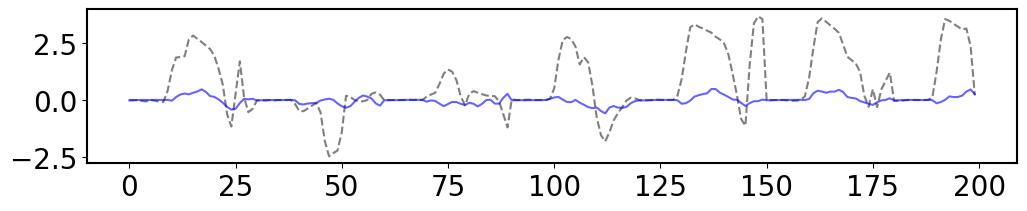

In [473]:
plt.figure(figsize=(12, 2))
plt.plot(data_loader.y[test].flatten()[:200], c='gray', linestyle='dashed', label='observed');
plt.plot(y_hat.flatten()[:200], c='blue', alpha=.6, label='predicted');

In [474]:
windowed_enc_all, half_window_size, n_windows = decoder.sliding_window(
    enc_all, 
    data_loader.n_trials,
    window_size = 7
)
windowed_y = data_loader.y[:,half_window_size:n_windows].reshape(-1,1)

In [475]:
x_by_trial = windowed_enc_all.reshape((data_loader.n_trials, -1))
y_by_trial = windowed_y.reshape((data_loader.n_trials, -1))
x_train, x_test = x_by_trial[train], x_by_trial[test]
y_train, y_test = y_by_trial[train], y_by_trial[test]

x_train = x_train.reshape((-1, windowed_enc_all.shape[1]))
x_test = x_test.reshape((-1, windowed_enc_all.shape[1]))
y_train = y_train.flatten()
y_test = y_test.flatten()

In [476]:
ridge = Ridge(alpha=10000)
ridge.fit(x_train, y_train)
y_pred = ridge.predict(x_test)

In [477]:
print(f'R2 = {r2_score(y_test, y_pred):.3f}')
print(f'MSE = {mean_squared_error(y_test, y_pred):.3f}')

R2 = -0.743
MSE = 3.671


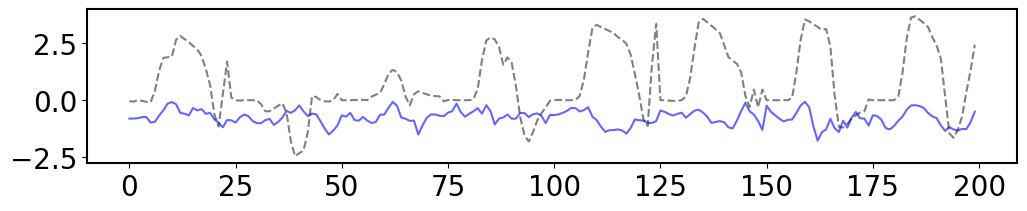

In [478]:
plt.figure(figsize=(12, 2))
plt.plot(y_test[:200], c='gray', linestyle='dashed', label='observed');
plt.plot(y_pred[:200], c='blue', alpha=.6, label='predicted');

#### KS & good IBL units

In [216]:
sorted_trials, good_sorted_trials, unsorted_trials, stim_on_times, np1_channel_map= preprocess.load_neural_data(
    pid=pid, 
    trial_data_path=trial_data_path,
    neural_data_path=neural_data_path,
    behavior_data_path=behavior_data_path,
    keep_active_trials=True, 
    roi='all',
    kilosort=True,
    triage=False,
    good_units=True,
    thresholding=True
)

n_trials = stim_on_times.shape[0]
sorted = np.vstack([sorted_trials[i] for i in np.arange(n_trials)]) 
spike_times = sorted[:,0]
spike_clusters = sorted[:,1]

sorted_neural_data = preprocess.compute_neural_activity(
    (spike_times, spike_clusters),
    stim_on_times,
    'sorted', 
    n_time_bins=30,
    regional=False
)
print(f'sorted neural data shape: {sorted_neural_data.shape}')

good_sorted = np.vstack([good_sorted_trials[i] for i in np.arange(n_trials)]) 
spike_times = good_sorted[:,0]
spike_clusters = good_sorted[:,1]

good_sorted_neural_data = preprocess.compute_neural_activity(
    (spike_times, spike_clusters),
    stim_on_times,
    'sorted', 
    n_time_bins=30,
    regional=False
)
print(f'good sorted neural data shape: {good_sorted_neural_data.shape}')

pid: dab512bd-a02d-4c1f-8dbc-9155a163efc0
eid: d23a44ef-1402-4ed7-97f5-47e9a7a504d9
found 83 good ibl units ..
1st trial stim on time: 17.56, last trial stim on time 2310.24
sorted neural data shape: (265, 514, 30)
good sorted neural data shape: (265, 83, 30)


In [226]:
x_train = sorted_neural_data.reshape(-1, sorted_neural_data.shape[1] * sorted_neural_data.shape[2])[train]
x_test = sorted_neural_data.reshape(-1, sorted_neural_data.shape[1] * sorted_neural_data.shape[2])[test]
y_train = data_loader.y[train]

ridge = Ridge(alpha=10000)
ridge.fit(x_train, y_train)
y_hat = ridge.predict(x_test)

In [227]:
print(f'R2 = {r2_score(data_loader.y[test], y_hat):.3f}')
print(f'MSE = {mean_squared_error(data_loader.y[test], y_hat):.3f}')

R2 = 0.095
MSE = 1.381


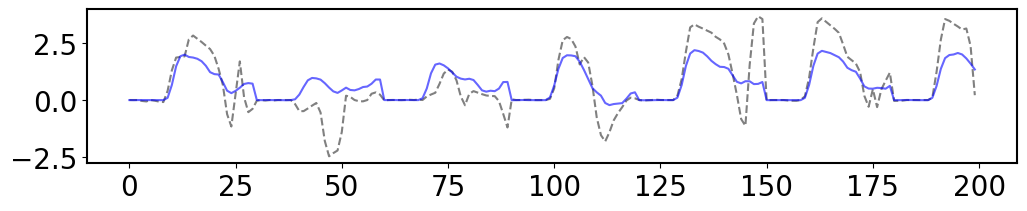

In [228]:
plt.figure(figsize=(12, 2))
plt.plot(data_loader.y[test].flatten()[:200], c='gray', linestyle='dashed', label='observed');
plt.plot(y_hat.flatten()[:200], c='blue', alpha=.6, label='predicted');

In [217]:
windowed_sorted, half_window_size, n_windows = decoder.sliding_window(
    sorted_neural_data, 
    data_loader.n_trials,
    window_size = 7
)

windowed_good_units, half_window_size, n_windows = decoder.sliding_window(
    good_sorted_neural_data, 
    data_loader.n_trials,
    window_size = 7
)
windowed_y = data_loader.y[:,half_window_size:n_windows].reshape(-1,1)

In [220]:
x_by_trial = windowed_sorted.reshape((data_loader.n_trials, -1))
y_by_trial = windowed_y.reshape((data_loader.n_trials, -1))
x_train, x_test = x_by_trial[train], x_by_trial[test]
y_train, y_test = y_by_trial[train], y_by_trial[test]

x_train = x_train.reshape((-1, windowed_sorted.shape[1]))
x_test = x_test.reshape((-1, windowed_sorted.shape[1]))
y_train = y_train.flatten()
y_test = y_test.flatten()

ridge = Ridge(alpha=10000)
ridge.fit(x_train, y_train)
y_pred = ridge.predict(x_test)

In [221]:
print(f'R2 = {r2_score(y_test, y_pred):.3f}')
print(f'MSE = {mean_squared_error(y_test, y_pred):.3f}')

R2 = 0.266
MSE = 1.546


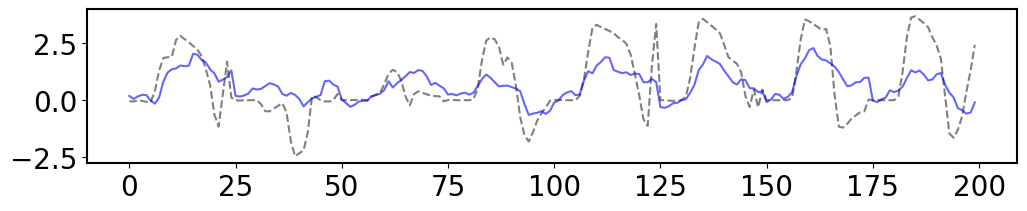

In [222]:
plt.figure(figsize=(12, 2))
plt.plot(y_test[:200], c='gray', linestyle='dashed', label='observed');
plt.plot(y_pred[:200], c='blue', alpha=.6, label='predicted');

In [229]:
x_train = good_sorted_neural_data.reshape(-1, good_sorted_neural_data.shape[1] * good_sorted_neural_data.shape[2])[train]
x_test = good_sorted_neural_data.reshape(-1, good_sorted_neural_data.shape[1] * good_sorted_neural_data.shape[2])[test]
y_train = data_loader.y[train]

ridge = Ridge(alpha=10000)
ridge.fit(x_train, y_train)
y_hat = ridge.predict(x_test)

In [230]:
print(f'R2 = {r2_score(data_loader.y[test], y_hat):.3f}')
print(f'MSE = {mean_squared_error(data_loader.y[test], y_hat):.3f}')

R2 = 0.063
MSE = 1.465


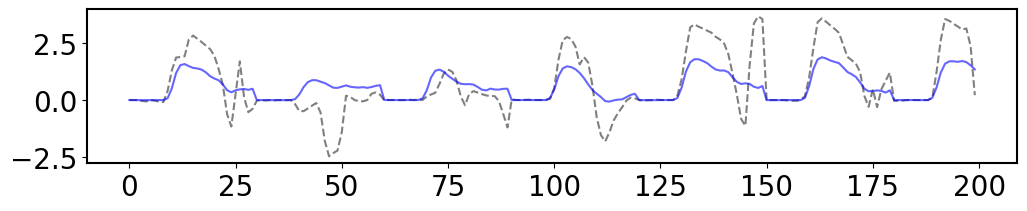

In [231]:
plt.figure(figsize=(12, 2))
plt.plot(data_loader.y[test].flatten()[:200], c='gray', linestyle='dashed', label='observed');
plt.plot(y_hat.flatten()[:200], c='blue', alpha=.6, label='predicted');

In [223]:
x_by_trial = windowed_good_units.reshape((data_loader.n_trials, -1))
y_by_trial = windowed_y.reshape((data_loader.n_trials, -1))
x_train, x_test = x_by_trial[train], x_by_trial[test]
y_train, y_test = y_by_trial[train], y_by_trial[test]

x_train = x_train.reshape((-1, windowed_good_units.shape[1]))
x_test = x_test.reshape((-1, windowed_good_units.shape[1]))
y_train = y_train.flatten()
y_test = y_test.flatten()

ridge = Ridge(alpha=2000)
ridge.fit(x_train, y_train)
y_pred = ridge.predict(x_test)

In [224]:
print(f'R2 = {r2_score(y_test, y_pred):.3f}')
print(f'MSE = {mean_squared_error(y_test, y_pred):.3f}')

R2 = 0.163
MSE = 1.762


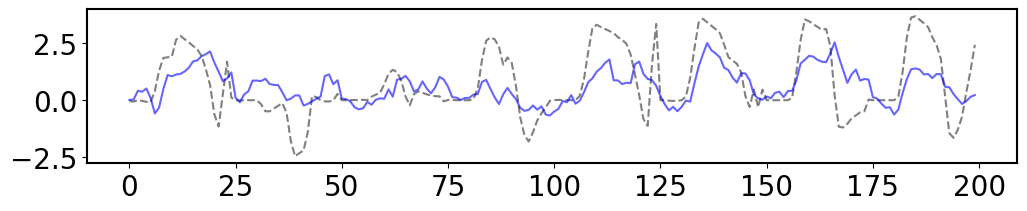

In [225]:
plt.figure(figsize=(12, 2))
plt.plot(y_test[:200], c='gray', linestyle='dashed', label='observed');
plt.plot(y_pred[:200], c='blue', alpha=.6, label='predicted');